## Importing Necessary Libraries


In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

## Loading and Exploring Emotions Dataset


In [2]:
emotions_dataset = pd.read_csv('emotions_dataset.csv')
emotions_dataset['Emotions'].value_counts()

joy         12021
sadness      7685
fear         6735
anger        5333
surprise     4062
neutral      2254
disgust       856
shame         146
Name: Emotions, dtype: int64

## Visualizing Emotion Distribution


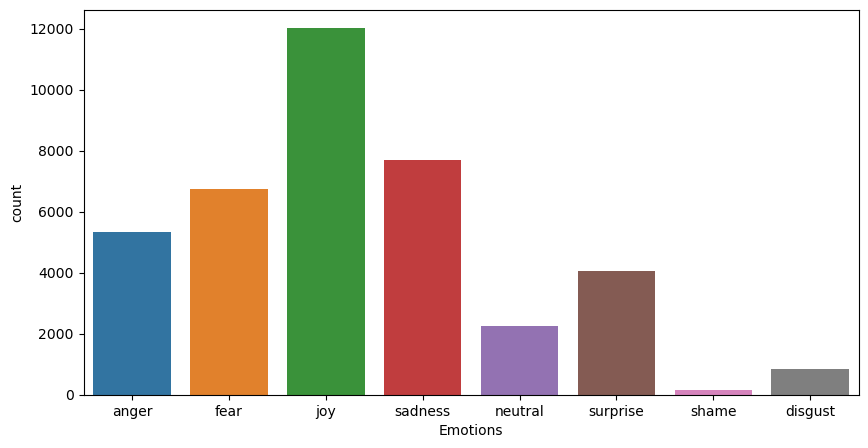

In [3]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotions', data=emotions_dataset)
plt.show()

## Text Pattern Removal Function


In [4]:
# Remove Unwanted text pattern and word from the tweets
def remove_text(input_txt, pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

## Removing User Mentions from Tweets


In [5]:
# 1. Remove @user
emotions_dataset['clean_tweets'] = np.vectorize(remove_text)(emotions_dataset['Tweet'],"@[\w]*")

## Resetting DataFrame Index and Displaying Head


In [6]:
emotions_dataset = emotions_dataset.reset_index(drop=True)
emotions_dataset.head()

,Tweet,Emotions,clean_tweets
0,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,shut up hashtags are cool #offended
1,it makes me so fucking irate jesus. nobody is ...,anger,it makes me so fucking irate jesus. nobody is ...
2,@MisterAK47 it's very telling that racist bigo...,anger,it's very telling that racist bigots always r...
3,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,if he can't come to my Mum'a 60th after 25...
4,Lol little things like that make me so angry x,anger,Lol little things like that make me so angry x


## Further Text Preprocessing: Removing Punctuation, Numbers, Special Characters, and Short Words


In [34]:
# Remove Punctuation, Numbers, Special Characters
emotions_dataset['clean_tweets'] = emotions_dataset['clean_tweets'].str.replace("[^a-zA-Z#]", " ", regex=True)

# Remove Short Words like: hmm, oh, etc.
emotions_dataset['clean_tweets'] = emotions_dataset['clean_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

final_df = emotions_dataset.drop(['Tweet'], axis=1)


## Checking the Shape of the Final DataFrame


In [35]:
final_df.shape

(39092, 2)

## Tokenizing Cleaned Tweets


In [9]:
tokenized_question1 = final_df['clean_tweets'].apply(lambda x: x.split()) #tokenizing
tokenized_question1.head()

0                    [shut, hashtags, cool, #offended]
1    [makes, fucking, irate, jesus, nobody, calling...
2    [very, telling, that, racist, bigots, always, ...
3    [come, after, tweets, then, should, #bitter, #...
4            [little, things, like, that, make, angry]
Name: clean_tweets, dtype: object

## Importing and Initializing WordNet Lemmatizer


In [10]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmaObj = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADITYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADITYA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Lemmatizing Tokenized Tweets



In [11]:
%%time
lemmatize_tweets = tokenized_question1.apply(lambda x: [lemmaObj.lemmatize(word) for word in x])
lemmatize_tweets.head()

CPU times: total: 2.42 s
Wall time: 2.53 s


0                    [shut, hashtags, cool, #offended]
1    [make, fucking, irate, jesus, nobody, calling,...
2    [very, telling, that, racist, bigot, always, r...
3    [come, after, tweet, then, should, #bitter, #s...
4             [little, thing, like, that, make, angry]
Name: clean_tweets, dtype: object

## Adding Lemmatized Tweets to the Final DataFrame


In [12]:
final_df['lemmatize_tweets'] = lemmatize_tweets
final_df['lemmatize_tweets'] = final_df['lemmatize_tweets'].apply(lambda x: ' '.join(x))
final_df.head()

,Emotions,clean_tweets,lemmatize_tweets
0,anger,shut hashtags cool #offended,shut hashtags cool #offended
1,anger,makes fucking irate jesus nobody calling like ...,make fucking irate jesus nobody calling like h...
2,anger,very telling that racist bigots always resort ...,very telling that racist bigot always resort i...
3,anger,come after tweets then should #bitter #soreloser,come after tweet then should #bitter #soreloser
4,anger,little things like that make angry,little thing like that make angry


## Importing Necessary TensorFlow and Keras Modules for Model Building


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

## Creating One-Hot Representations for Text Data


In [14]:
### Vocabulary size
vocab_size=5000

### onehot representation
onehot_repr=[one_hot(words,vocab_size)for words in final_df['lemmatize_tweets']] 
onehot_repr[:5]

[[2046, 763, 452, 4661],
 [1653, 4742, 2290, 4076, 2238, 637, 4464, 2675, 3049, 1164, 2084, 4517, 3299],
 [2586,
  3786,
  2840,
  264,
  2980,
  4228,
  3167,
  689,
  4464,
  2840,
  4402,
  2221,
  1930,
  264,
  2980],
 [2226, 4015, 626, 3187, 3473, 1538, 4025],
 [3403, 2096, 4464, 2840, 1653, 4899]]

## Padding Text Data for Equal Length


In [15]:
# padding the data for equal shape
sent_length=50
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  763  452 4661]
 [   0    0    0 ... 2084 4517 3299]
 [   0    0    0 ... 1930  264 2980]
 ...
 [   0    0    0 ...    0 2920 4511]
 [   0    0    0 ... 3434 2067 3282]
 [   0    0    0 ...  754 1701 2370]]


## Checking the Shapes of Data



In [16]:
embedded_docs.shape,final_df['Emotions'].shape

((39092, 50), (39092,))

## Preparing Data for Model Training



In [17]:
train = embedded_docs
target = final_df['Emotions']
train.shape, target.shape

((39092, 50), (39092,))

## Importing `to_categorical` Function from Keras


In [18]:
from tensorflow.keras.utils import to_categorical

## Encoding Emotion Labels


In [19]:
labels = final_df['Emotions'].replace({'anger':0,'fear':1,'joy':2,'sadness':3,'neutral':4,'surprise':5,'shame':6,'disgust':7})
binary_labels = to_categorical(labels,num_classes=8)
binary_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Splitting Data into Training and Testing Sets


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, binary_labels, test_size=0.30, random_state=0)
emb_dim = 2

## Building a Bidirectional LSTM Model


In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 4, input_length=embedded_docs.shape[1]))
model.add(Bidirectional(LSTM(256, dropout=0.3)))
model.add(Dense(8,activation='relu'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 4)             20000     
                                                                 
 bidirectional (Bidirection  (None, 512)               534528    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 558632 (2.13 MB)
Trainable params: 558632 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Bidirectional LSTM Model with Early Stopping


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stop])

Epoch 1/20
856/856 [==============================] - 226s 260ms/step - loss: 2.1099 - accuracy: 0.3474 - val_loss: 1.9268 - val_accuracy: 0.4223
Epoch 2/20
856/856 [==============================] - 231s 270ms/step - loss: 2.0109 - accuracy: 0.4131 - val_loss: 2.1099 - val_accuracy: 0.4303
Epoch 3/20
856/856 [==============================] - 138s 162ms/step - loss: 1.9647 - accuracy: 0.4442 - val_loss: 1.9381 - val_accuracy: 0.4590
Epoch 4/20
856/856 [==============================] - 137s 160ms/step - loss: 1.9848 - accuracy: 0.4717 - val_loss: 2.0048 - val_accuracy: 0.4697
Epoch 5/20
856/856 [==============================] - 134s 156ms/step - loss: 1.9434 - accuracy: 0.4816 - val_loss: 1.8584 - val_accuracy: 0.4769
Epoch 6/20
856/856 [==============================] - 132s 154ms/step - loss: 1.9445 - accuracy: 0.4963 - val_loss: 1.7712 - val_accuracy: 0.5103
Epoch 7/20
856/856 [==============================] - 150s 175ms/step - loss: 1.9495 - accuracy: 0.5062 - val_loss: 1.8789 -

## Evaluating the Model on Test Data


In [23]:
model.evaluate(X_test,y_test)

367/367 [==============================] - 12s 33ms/step - loss: 1.6993 - accuracy: 0.5227


[1.6993000507354736, 0.5226807594299316]

## Plotting Model Training and Validation Loss


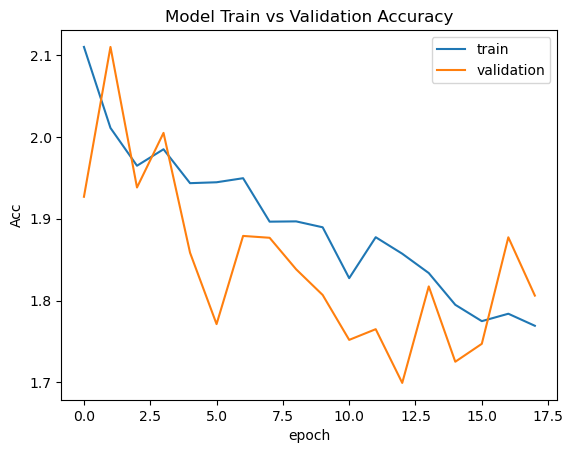

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

## Making Predictions on Test Data


In [25]:
y_pred = model.predict(X_test)
y_pred

367/367 [==============================] - 13s 33ms/step


array([[ 0.        ,  0.        , 14.855847  , ...,  0.56686306,
         0.        ,  0.        ],
       [ 2.438671  ,  0.        ,  8.359122  , ...,  0.43411636,
         0.        ,  0.        ],
       [ 0.5426268 ,  0.        , 11.226996  , ...,  1.0651909 ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , 15.472138  , ...,  0.3047477 ,
         0.        ,  0.        ],
       [ 1.5521034 ,  2.7081728 ,  6.203133  , ...,  1.1945465 ,
         0.        ,  0.        ],
       [ 2.2491522 ,  0.17702621,  8.45345   , ...,  0.12761796,
         0.        ,  0.        ]], dtype=float32)

## Extracting Predicted Classes from Model Predictions


In [30]:
y_classes = [np.argmax(y) for y in y_pred]


## Encoding Predicted Classes


In [27]:
y_pred = to_categorical(y_classes,num_classes=8)

## Generating Classification Report


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.45      0.11      0.18      1580
           1       0.68      0.56      0.62      2031
           2       0.52      0.86      0.65      3645
           3       0.37      0.45      0.41      2300
           4       0.71      0.69      0.70       692
           5       0.76      0.14      0.23      1214
           6       1.00      0.00      0.00        37
           7       1.00      0.00      0.00       229

   micro avg       0.52      0.52      0.52     11728
   macro avg       0.69      0.35      0.35     11728
weighted avg       0.56      0.52      0.48     11728
 samples avg       0.52      0.52      1.00     11728



## Visualizing Model Accuracy


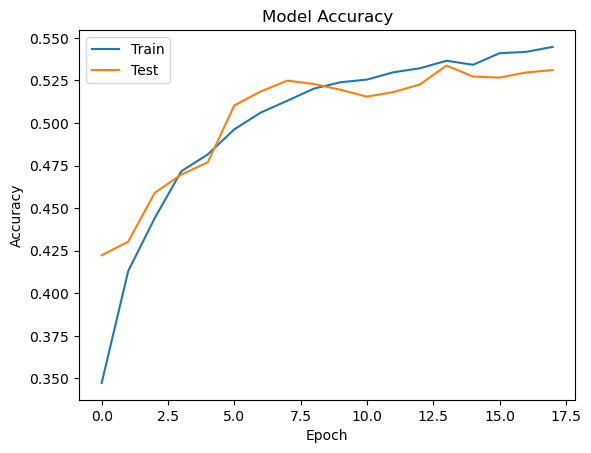

In [36]:
# Step 7: Visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculating Hamming Loss Score


In [43]:
from sklearn.metrics import hamming_loss
hamming_loss_score = hamming_loss(y_test, y_pred)
print("Hamming Loss Score: ",hamming_loss_score)


Hamming Loss Score:  0.11932980900409276


## Calculating and Visualizing Multilabel Confusion Matrices


Unique Labels: ['anger' 'fear' 'joy' 'sadness' 'neutral' 'surprise' 'shame' 'disgust']


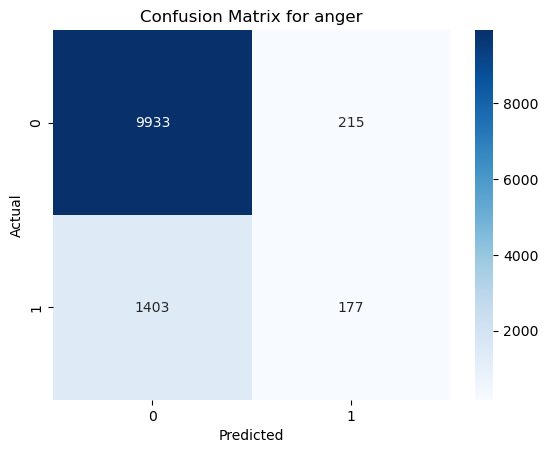

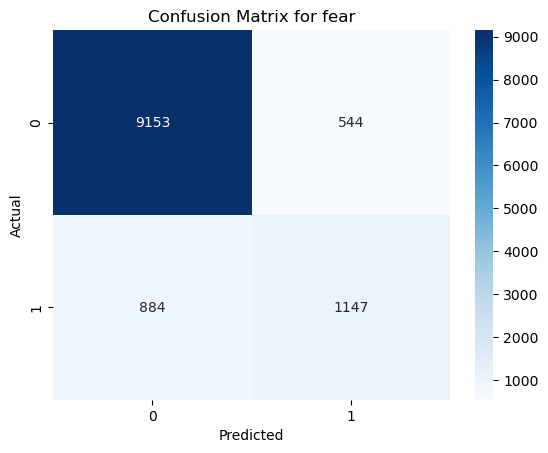

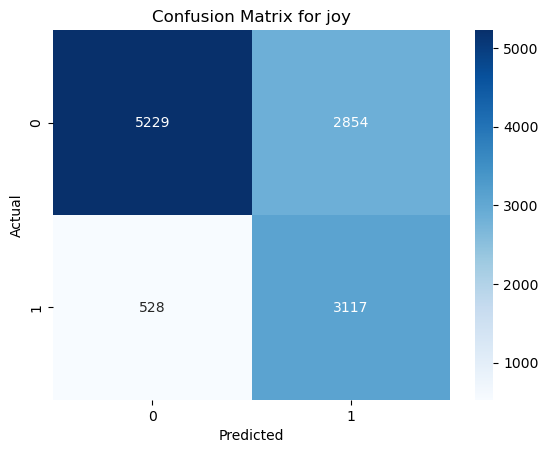

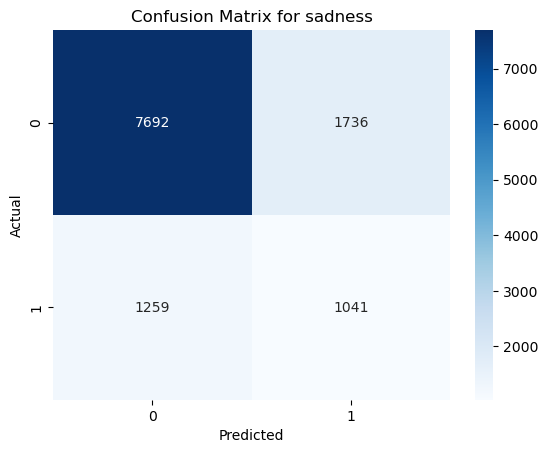

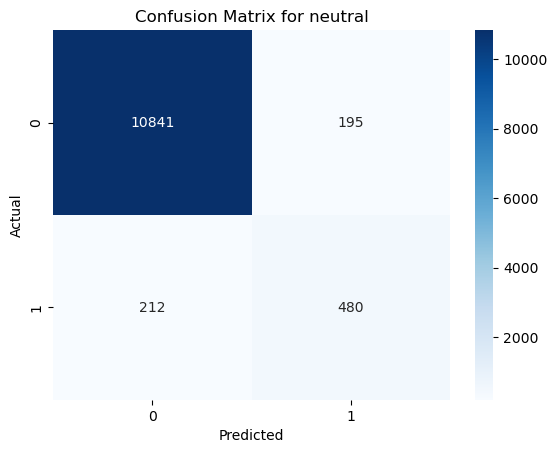

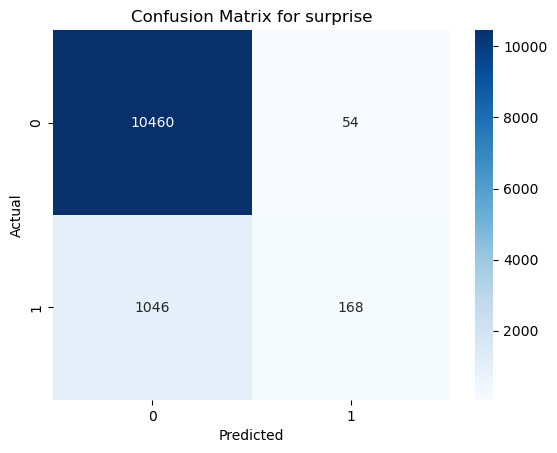

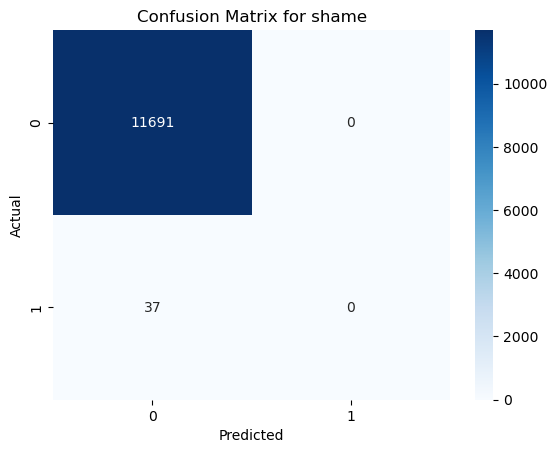

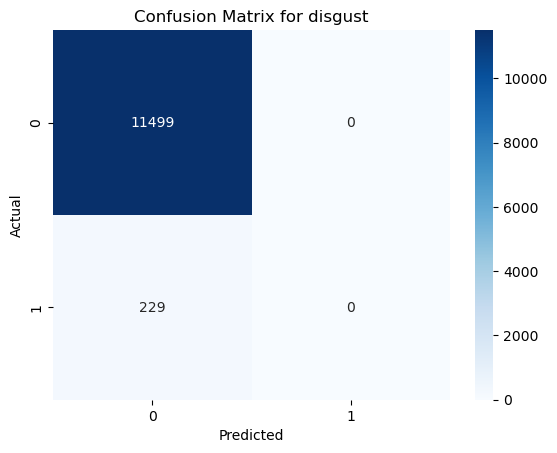

In [54]:
from sklearn.metrics import multilabel_confusion_matrix
unique_labels = emotions_dataset['Emotions'].unique()

# Print the unique labels
print("Unique Labels:", unique_labels)
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

# Define label names for your multi-label classification
label_names = ['anger', 'fear' ,'joy' ,'sadness' ,'neutral', 'surprise', 'shame' ,'disgust']  # Replace with your actual label names

# Assuming y_test and y_pred are in the format of multi-label classification

# Calculate the multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for each label with labels
for i in range(len(mcm)):
    label_cm = mcm[i]
    sns.heatmap(label_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


## Preprocessing and Making Predictions on New Data


In [29]:
actual_lables = {'anger':0,'fear':1,'joy':2,'sadness':3,'neutral':4,'surprise':5,'shame':6,'disgust':7}
actual_lables = {v: k for k, v in actual_lables.items()}
sent = "We join millions of fans in mourning the passing of the immensely talented Mark Margolis, who - with his eyes, a bell, and very few words - turned Hector Salamanca into one of the most unforgettable characters in the history of television. He will be missed."
onehot_repr1 = [one_hot(words,vocab_size) for words in [sent]]

def preprocess_data(data):
  onehot_repr = [one_hot(words,vocab_size) for words in [data]]
  sent_length=50
  docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

  return docs
model.predict(preprocess_data(sent))

prediction = np.argmax(model.predict(preprocess_data(sent)))

actual_lables[prediction]


1/1 [==============================] - 0s 21ms/step


'fear'

## Saving the Trained Model


In [55]:
import os
from tensorflow.keras.models import load_model

# Save the trained model to an HDF5 file
model.save("emix.model.h5")

# Get the current working directory
current_directory = os.getcwd()

# Print the current directory
print("Model saved in directory:", current_directory)

Model saved in directory: C:\Users\ADITYA


C:\Users\ADITYA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
